In [1]:
import unidecode
import random
import re

file = unidecode.unidecode(open(r"C:\Users\arun\Desktop\Projects\practical-pytorch\char-rnn-generation\train_dataset_abc_notation.txt").read())
file_len = len(file)
print('file_len =', file_len)
start_indices = [each.start() for each in re.finditer(r'\nEOS\n', file)]
print(f"n_start indices : {len(start_indices)}")

file_len = 455582
n_start indices : 1037


In [2]:
def flatten_list(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    
    return flat_list

In [3]:
##we are creating a notation to index dictionary and index to notation dictionary and saving it
import os
from tqdm import tqdm
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

if not os.path.isfile('.'+os.sep+'notation_to_idx.pkl'):    
    flat_data = set(file)
    notation_to_idx = {}
    for idx,each in tqdm(enumerate(flat_data)):
        notation_to_idx[each] = idx
    save_obj(notation_to_idx, 'notation_to_idx')

if not os.path.isfile('.'+os.sep+'idx_to_notation.pkl'):
    idx_to_notation = {}
    for idx,each in tqdm(enumerate(flat_data)):
        idx_to_notation[idx] = each
    save_obj(idx_to_notation, 'idx_to_notation')

In [4]:
##if the object already exists then load it
import pickle
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
notation_to_idx = load_obj('notation_to_idx')
idx_to_notation = load_obj('idx_to_notation')

In [5]:
##code to load and sample random sequence of strings
chunk_len = 500

def random_chunk():
    start_index = random.choice(start_indices)+len("\nEOS\n")
    end_index = start_index + chunk_len + 1
    train_chunk = file[start_index:min(file_len,end_index)]
    if len(train_chunk) < chunk_len:
        return random_chunk()
    return train_chunk
print("".join(random_chunk()))


X: 55
T:Redesdale Hornpipe
% Nottingham Music Database
S:NPTB
M:4/4
L:1/8
R:Hornpipe
K:G
P:A
(3def|"G"gdBd GB(3def|"G"gdBd G2"g#"AB|"Am"cAFA "D"DFAc|"C"ed^cd "D7"B2(3def|
"G"gdBd GB(3def|"G"gdBd G2"g#"AB|"Am"cAFA "D7"DFAB|"G"A2G2 G2:|
P:B
GA|"G"BGFG DGFG|"G"BGFG D2AB|"Am"cAFA "D"DFAc|"C"ed^cd "D7"B2GA|
"G"BGFG DGFG|"G"BGFG D2AB|"Am"cAFA "D7"DFAB|"G"A2G2 G2:|
EOS

X: 56
T:Rights of Man
% Nottingham Music Database
S:KCC p27
M:4/4
L:1/8
R:Hornpipe
K:G
P:A
GA|"Em"BcAB GAFG|"Em"EFGA B2ef|"Em"gfed "G"


In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

##creating the RNN class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        ##input size same as the number of unique characters
        self.input_size = input_size
        ##hidden size decides the number of LSTM units. The output size is same as the hidden size
        self.hidden_size = hidden_size
        self.output_size = output_size
        ##number of layers for the GRU which by default is 1
        self.n_layers = n_layers
        
        ##initialize the embedding layer to convert the words to their embedding vectors
        self.encoder = nn.Embedding(input_size, hidden_size)
        ###gru with the same input and hidden size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        ###decoder is the a linear layer whose output is of dimension output_size(generally the number of characters 
        ##because that is what we are predicting)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        ##the forward propogation
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        ##hidden vector initialized with all zeros
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [7]:
# Turn string into list of index notations
def music_tensor(notations_list):
    tensor = torch.zeros(len(notations_list)).long()
    for c in range(len(notations_list)):
        tensor[c] = notation_to_idx[notations_list[c]]
    return Variable(tensor)

print(music_tensor(list("X: 47\nT:Navvie")))

tensor([66, 43,  7, 82, 15, 37, 24, 43,  8, 28, 63, 63, 90, 88])


In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = music_tensor(chunk[:-1])
    target = music_tensor(chunk[1:])
    return inp, target

print(random_training_set())

(tensor([37, 66, 43,  7, 13, 37, 24, 43, 64,  0,  7,  3, 62, 69,  0, 88, 41,  7,
        24, 77, 88,  7, 45, 88, 63, 90, 54, 37, 42,  7,  8, 36, 20, 20, 90, 34,
        81, 77, 28, 69,  7, 67, 62, 55, 90, 52,  7, 45, 28, 20, 28, 44, 28, 55,
        88, 37, 23, 43, 86, 88, 63, 90, 34,  7, 49, 12, 90, 81, 81, 55, 35,  7,
        63, 90, 28,  7, 78, 46, 37, 67, 43, 82,  1, 82, 37, 86, 43, 57, 37, 67,
        43, 82,  1, 82, 37, 70, 43, 13,  1, 82, 37, 49,  1, 72, 52,  1, 72,  2,
        21, 57, 21, 88, 88,  1, 72, 88,  1, 72,  7,  9,  9,  2, 21, 57, 21, 28,
        28,  7,  9, 88,  2, 21, 57, 21, 88, 28,  7,  9, 88,  2, 21, 78, 21, 81,
        14, 88,  2, 21, 78, 21, 88,  1, 72, 81,  1, 72, 44,  1, 72, 88,  1, 72,
         7, 81,  1, 72, 44,  1, 72, 88,  1, 72, 81,  1, 72,  2, 37, 21, 78, 21,
        44,  1, 72, 88,  1, 72, 81,  1, 72, 44,  1, 72,  7, 81,  9,  2, 21, 78,
        15, 21, 88,  1, 72,  9,  1, 72, 81,  1, 72, 88,  1, 72,  7, 21,  9, 75,
        21,  9, 21, 81, 75, 21, 88,  2,

In [10]:
def evaluate(prime_notation='2.7', predict_len=100, temperature=0.8, use_multinomial = True):
    hidden = decoder.init_hidden()
    prime_input = music_tensor(prime_notation)
    predicted = prime_notation

    # Use priming string to "build up" hidden state
    for p in range(len(prime_notation) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    
    for p in range(predict_len):
        if not use_multinomial:
            output, hidden = decoder(inp, hidden)
            _, index_top = torch.topk(output.view(-1),1)
            predicted_notation = idx_to_notation[index_top.numpy()[0]]
            predicted += predicted_notation
            inp = music_tensor([predicted_notation])

        else:
            output, hidden = decoder(inp, hidden)            
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            # Add predicted character to string and use as next input
            predicted_notation = idx_to_notation[top_i.view(-1).numpy()[0]]
            predicted += predicted_notation
            inp = music_tensor([predicted_notation])

            
#     for p in range(predict_len):
#         output, hidden = decoder(inp, hidden)
        
#         # Sample from the network as a multinomial distribution
#         output_dist = output.data.view(-1).div(temperature).exp()
#         top_i = torch.multinomial(output_dist, 1)[0]
        
#         # Add predicted character to string and use as next input
#         predicted_char = all_characters[top_i]
#         predicted += predicted_char
#         inp = char_tensor(predicted_char)

    return "".join(predicted)

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [12]:
n_epochs = 20000
print_every = 100
plot_every = 10
n_notations = len(notation_to_idx)
hidden_size = n_notations-30
n_layers = 1
lr = 0.005

decoder = RNN(n_notations, hidden_size, n_notations, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate("X: 57\nT", 350, use_multinomial=False), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 46s (100 0%) 1.4577]
X: 57
T:Trad Music Database
S:Kevin Briggs, via PR
M:4/4
L:1/4
K:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P:A
P: 

 32s (200 1%) 1.7516]
X: 57
T:Mings
% Nottingham Music Database
S:Trad, via EF
M:4/4
L:1/4
K:G
P:A
|:"Em"BAB "E7"BAB|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ede "E7"ede|"Em"ed 

 19s (300 1%) 1.2779]
X: 57
T:The Laness 1989, via PR
M:4/4
L:1/4
K:D
"D"F2 "D"A/2B/2A/2|"D"A/2A/2 "D"A/2B/2A/2|"D"A/2B/2 "D"A/2B/2A/2|"D"A/2B/2 "D"A/2B/2A/2|"D"d/2B/2 d/2c/2d/2|"G"B/2B/2 d/2B/2|"G"d/2B/2 d/2B/2|"G"d/2B/2 d/2B/2|"G"d/2B

S:via PR 

 26s (2300 11%) 0.8407]
X: 57
T:The Tripp
% Nottingham Music Database
S:via PR
M:4/4
L:1/4
K:G
"G"G3::
"D7"AB BA|"G"BG G:|
EOS

X: 63
T:The Tripp
% Nottingham Music Database
S:via PR
M:4/4
L:1/4
K:G
"G"G3::
"D7"AB BA|"G"BG G:|
EOS

X: 63
T:The Tripp
% Nottingham Music Database
S:via PR
M:4/4
L:1/4
K:G
"G"G3::
"D7"AB BA|"G"BG G:|
EOS

X: 63
T:The Tripp
% Nottingham Music Database 

 13s (2400 12%) 1.0795]
X: 57
T:Sellon Sipers
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:G
P:A
d|"C"c3 "G"dBG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G"BGG|"C"A3 "G" 

 1s (2500 12%) 0.9607]
X: 57
T:Humusher Bros
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:D
A|"D"d2d "A7"e2e|"D"fed "A7"efg|"D"fed "A7"efg|"D"fed "A7"efg|"D"fed "A7"efg|"D"fed "A7"efg|"D"fed "A7"efg|"D"fed "A

A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/2A/2G/2|"D"F/2A/2F/2A/2 "A7"A/2B/ 

 55s (4500 22%) 0.9847]
X: 57
T:Cardstone Mark
% Nottingham Music Database
S:via PR
M:4/4
L:1/4
K:G
P:A
d/2c/2|"G"d/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2B/2 "D7"A/2G/2A/2A/2|"G"G/2G/2A/2 

 43s (4600 23%) 0.8406]
X: 57
T:The Wack Peake
% Nottingham Music Database
S:Mick Peat
M:4/4
L:1/4
K:G
"G"B/2c/2d/2e/2 "D7"d/2e/2f/2g/2|"G"g/2f/2g/2f/2 g/2a/2g/2f/2|"Am"a/2g/2e/2f/2 "D7"f/2g/2f/2e/2|"G"d/2B/2G/2B/2 "D7"A/2B/2A/2G/2|"G"Bd "D7"c/2B/2A/2G/2|"G"Bd "D7"c/2B/2A/2G/2|"G"Bd "D7"c/2B/2A/2G/2|"G"Bd dB/2c/2|"G"d/2B/2G/2B/2 "D7"A/2B/2A/2G/2|"G

cd|"D"d2d2 "A7"edcd|"D"d2f2  

 29s (6600 33%) 0.8184]
X: 57
T:Whith Water High
% Nottingham Music Database
S:Kevin Briggs, via EF
M:4/4
L:1/4
K:D
P:A
|:"D"A/2d/2f/2 d/2f/2d/2f/2|"A7"e/2d/2c/2B/2 A/2G/2A/2B/2|"A7"c/2B/2A/2G/2 "D"A/2F/2A/2F/2|"D"DF Ad|"A7"c/2B/2A/2G/2 A/2G/2A/2B/2|"A7"c/2B/2A/2G/2 A/2G/2A/2B/2|"A7"A/2B/2A/2G/2 A/2G/2A/2B/2|"A7"A/2B/2A/2G/2 A/2G/2A/2B/2|"A7"A/2B/2A/2G/2 "D"A/2F/2A/2F/2|"D"DF Ad 

 15s (6700 33%) 2.1628]
X: 57
T:Iand Reel
% Nottingham Music Database
S:via PR
M:4/4
L:1/4
K:G
"D7"A/2B/2A/2G/2 F/2A/2F/2A/2|"G"Bd dd/2B/2|"D7"A/2B/2A/2G/2 "G"G:|
P:B
d/2c/2|"G"Bd dd/2B/2|"G"Bd dd/2B/2|"D7"A/2B/2A/2G/2 "G"G:|
P:B
d/2c/2|"G"Bd dd/2B/2|"G"Bd dd/2B/2|"D7"A/2B/2A/2G/2 "G"G:|
P:B
d/2c/2|"G"Bd dd/2B/2|"G"Bd dd/2B/2|"D7"A/2B/2A/2G/2 "G"G:|
P:B
d/2c/2|"G"Bd dd/2B/2|"G"B 

 3s (6800 34%) 0.9338]
X: 57
T:Joh Farry Marick
% Nottingham Music Database
S:John Goodacre 1989, via Phil Rowe
M:6/8
K:D
A|"D"d3 d2:|
P:B
A/2B/2|"D"AFA d2d|"D"A2d "A7"e2d|"D"A2d "A7"e2d|"D"A2d "A7"e2d

KeyboardInterrupt: 

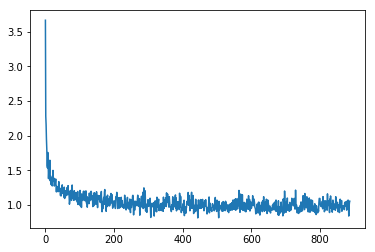

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [56]:
prime = """X: 3
T:The American Dwarf
% Nottingham Music Database
S:FTB, via EF
M:6/8
K:D
P:A"""
print(evaluate(prime, 1500, temperature=0.7, use_multinomial=True))

X: 3
T:The American Dwarf
% Nottingham Music Database
S:FTB, via EF
M:6/8
K:D
P:A
|:A|"D"def "G"bgd|"A7"efg age|"D"fdd "A7"Afe|"D"dAd fef|"Em"gBe "D"fed|
"G"BcB "D"AFA|"G"BGE GFE|"A"A3 Aee|"D"d2d cdA|"A7"BAA ABc|"D"d2A ABA|"G"Bcd "E7"B2d|
"A"c2E EFE|"D"Adf daf|"D"f2f f2f|"A"eee "D"d2:|
EOS

X: 44
T:Troms Hornpilye
% Nottingham Music Database
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:G
|:"G"g2B dfg|"G"gab ag|"C"gfe fec|"G"d3 g2f|"Em"efe "G"dBG|"D7"A3 A2A|"G"G2G G2A|"Em"BEF "Em"E2G|"Am"DEF EAB|"D7"cde d2c|
"G"g2g d2f|"G"g2g bgA|"G"B3 -d2c|B3 B3|"G"d2B "D"A2F|"D7"AGA AAF|
"G"GGB "D7"DFF|"G"GAB "C"cBc|"G"d2d "D"A2d|"G"B2B GBd|"C"EGE EFG|"C"E3 -EGB|"D7"d2c A2d|"G"BBG G3|"C"EGE G2:|
P:B
B|"D7"A3A AGF|"G"EGG GFE|"C"cde "D7"d2c|"G"d2d "A7"cBA|"D7"B2A ABA|"G"GBG G2D|"C"G2G GAB|"D7"A3 A2A|
"G"G2G G2B|"C"cde "G"ded|
"A7"ABc "D7"e2d|"G"B2B d|"C"c3 -c3|"G"B3 g2f|"G"gdB G3:|
EOS

X: 92
T:Bon Boo Brobe
% Nottingham Music Database
S:Mick Peat
M:4/4
L:1/8
R:Horth Iric Dow
M:4/4
L:1/4
K:

In [48]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in decoder.state_dict():
    print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in decoder_optimizer.state_dict():
    print(var_name, "\t", decoder_optimizer.state_dict()[var_name])

Model's state_dict:
encoder.weight 	 torch.Size([93, 143])
gru.weight_ih_l0 	 torch.Size([429, 143])
gru.weight_hh_l0 	 torch.Size([429, 143])
gru.bias_ih_l0 	 torch.Size([429])
gru.bias_hh_l0 	 torch.Size([429])
decoder.weight 	 torch.Size([93, 143])
decoder.bias 	 torch.Size([93])
Optimizer's state_dict:
state 	 {2743726223936: {'step': 8881, 'exp_avg': tensor([[ 0.0237, -0.0082,  0.0229,  ..., -0.0028,  0.0012, -0.0251],
        [-0.0168, -0.0539,  0.0622,  ..., -0.0936,  0.0875, -0.0091],
        [-0.0939, -0.0507,  0.1590,  ..., -0.0479,  0.2113,  0.0404],
        ...,
        [-0.0127, -0.0273,  0.0157,  ...,  0.0914,  0.0101,  0.0292],
        [-0.0674, -0.3658,  0.2775,  ...,  0.0428,  0.0553, -0.2128],
        [-0.0001,  0.0053,  0.0030,  ...,  0.0217, -0.0035, -0.0046]]), 'exp_avg_sq': tensor([[0.0792, 0.2597, 0.2116,  ..., 0.1513, 0.0694, 0.0681],
        [0.6841, 1.2516, 0.8887,  ..., 0.9137, 0.8318, 0.8663],
        [0.2559, 0.3201, 0.3006,  ..., 0.3239, 0.4801, 0.2487],
 

        2.0651e+00, 6.7601e+00, 5.5864e-01])}}
param_groups 	 [{'lr': 0.005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [2743726223936, 2743726224080, 2743726224872, 2743726224656, 2743726224800, 2743726224728, 2743726224584]}]


In [49]:
torch.save(decoder.state_dict(), "music_gen.pth")